This notebook is for the Math 302 data project.
Created by Alice Lundgren and Jared Winn

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

### Data Cleaning

The first section of this notebook deals with loading and cleaning the data.
We have chosen to use the US traffic accidents dataset, and downloaded it from Kaggle. 
To apply this to another dataset you must download a CSV version of your dataset and change the file paths. However, be aware that much of the cleaning and reformatting we do here is not universal, we treat different features of the dataset differently, and often specify rule for cleaning by feature. 

In [3]:
# Replace with the path to desired dataset.
path = "US_Accidents_March23.csv"
# Note that the datset is very large, as such execution of this cell can take some time. 
df = pd.read_csv(path)

Now that we have loaded the data we wish to study and clean it. 

In [4]:
print(df.shape)
df.head()

(7728394, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


We find that the data has 7728394 rows and 46 columns. We can already see that some of the columns will need to be trimmed (ie ID and source) and that there are several NaN values which we will need to take care of.  

In [5]:
# We drop the ID and source columns
df = df.drop(columns=["ID", "Source"])

Looking at the attributes summary on Kaggle we identify more columns to remove:
* Description ~ Natural language not parsable by simple ML techniques
* Country ~ All data is from the United States
* Timezone ~ Redundent given we already have a precise lat-long position
* Airport_Code ~ Redundent given we already have a precise lat-long position
* Street ~ Does not provide information that can be easily used by a simple ML model



We will keep several other columns, such as City, State, ect to determine how they correlate to accidents. 

In [6]:
df = df.drop(columns=["Description", "Country", "Timezone", "Airport_Code","Street" ])

Now we want to get an idea of how much data is missing, specifically if there are any rows or columns that are almost completely empty. 

In [7]:
rows, cols = df.shape
missing = df.isna()
counts = missing.sum()
for col, cnt in counts[counts > 0].sort_values().items():
    pct = (cnt / rows)
    print(f"{col}: missing {pct:.3f} %")

City: missing 0.000 %
Zipcode: missing 0.000 %
Astronomical_Twilight: missing 0.003 %
Civil_Twilight: missing 0.003 %
Sunrise_Sunset: missing 0.003 %
Nautical_Twilight: missing 0.003 %
Weather_Timestamp: missing 0.016 %
Pressure(in): missing 0.018 %
Temperature(F): missing 0.021 %
Weather_Condition: missing 0.022 %
Humidity(%): missing 0.023 %
Wind_Direction: missing 0.023 %
Visibility(mi): missing 0.023 %
Wind_Speed(mph): missing 0.074 %
Wind_Chill(F): missing 0.259 %
Precipitation(in): missing 0.285 %
End_Lng: missing 0.440 %
End_Lat: missing 0.440 %


In [8]:
# What would happen if we drop every row with Nan values?
test = df.dropna()
print(test.shape)

(3562877, 39)


We identify the following columns as potential problems:
* Wind Chill
* Precipitation
* End_Lng
* End_lat

Even though we could drop every entry with NaN values and still have a sizable dataset, for the sake of this assingment we will find other ways to clean the data

In [9]:
# Inspect values of Wind_Chill
print(df['Wind_Chill(F)'].describe())

# Let's see how many entries match Temperature
print((df['Wind_Chill(F)'] == df['Temperature(F)']).sum())

# It seems reasonable to replace NaN Wind_Chill values with the corrosponding value in Temperature. 
df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Temperature(F)'])

count    5.729375e+06
mean     5.825105e+01
std      2.238983e+01
min     -8.900000e+01
25%      4.300000e+01
50%      6.200000e+01
75%      7.500000e+01
max      2.070000e+02
Name: Wind_Chill(F), dtype: float64
4429402


In [10]:
# Inspect values of Precipitation 
print(df['Precipitation(in)'].describe())

# Let's see how many entries are zero
print((df['Precipitation(in)'] == 0).sum())

# It seems pretty safe to assume that NaN values of preciptation are 0
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0) 

count    5.524808e+06
mean     8.407210e-03
std      1.102246e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.647000e+01
Name: Precipitation(in), dtype: float64
4991718


We now only have the ending latitude and longitude to deal with. Since the distance of the effect on traffic is already recorded, and we have the initial point, and a large portion of the dataset has Nan Values in these columns, it makes sense to delete them. 

In [11]:
df = df.drop(columns = ["End_Lng", "End_Lat"])

Now we can clean up the rest of the NaNs without losing too much of the dataset. 

In [12]:
df = df.dropna()

In [13]:
# Number of entries saved through our data cleaning
print(df.shape[0] - test.shape[0])

3498896


Next we move on to checking if the data is in the correct format, if there are duplicates, and if all the values fall in the correct ranges. 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7061773 entries, 2 to 7728393
Data columns (total 37 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   End_Time               object 
 3   Start_Lat              float64
 4   Start_Lng              float64
 5   Distance(mi)           float64
 6   City                   object 
 7   County                 object 
 8   State                  object 
 9   Zipcode                object 
 10  Weather_Timestamp      object 
 11  Temperature(F)         float64
 12  Wind_Chill(F)          float64
 13  Humidity(%)            float64
 14  Pressure(in)           float64
 15  Visibility(mi)         float64
 16  Wind_Direction         object 
 17  Wind_Speed(mph)        float64
 18  Precipitation(in)      float64
 19  Weather_Condition      object 
 20  Amenity                bool   
 21  Bump                   bool   
 22  Crossing               

We see that the time columns are objects, but we need to check that they are date time objects

In [15]:
df['Start_Time'].head()

2    2016-02-08 06:49:27
3    2016-02-08 07:23:34
4    2016-02-08 07:39:07
5    2016-02-08 07:44:26
6    2016-02-08 07:59:35
Name: Start_Time, dtype: object

In [16]:
df['End_Time'].head()

2    2016-02-08 07:19:27
3    2016-02-08 07:53:34
4    2016-02-08 08:09:07
5    2016-02-08 08:14:26
6    2016-02-08 08:29:35
Name: End_Time, dtype: object

In [17]:
df['Weather_Timestamp'].head()

2    2016-02-08 06:56:00
3    2016-02-08 07:38:00
4    2016-02-08 07:53:00
5    2016-02-08 07:51:00
6    2016-02-08 07:56:00
Name: Weather_Timestamp, dtype: object

So we need to convert to a date time object 

In [18]:
# Convert to date time object
df['Start_Time'] = df['Start_Time'].str.replace(r'\.\d+', '', regex=True)
df['End_Time']   = df['End_Time'].str.replace(r'\.\d+', '', regex=True)
df['Weather_Timestamp']   = df['Weather_Timestamp'].str.replace(r'\.\d+', '', regex=True)

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time']   = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])

Next we will check if there are duplicate entries

In [19]:
print(df.duplicated().sum())

132349


This is quite a lot, we checked, and before any cleaning was done there were 0 duplicate entries, after removing the ID and source there were 102338, and after removing the description column there were 121499. 

Given these numbers, it seems likely that the three seperate sources often recorded the same accident, with differences in the source and description column accounting for almost all of the duplicates. As such we will drop them. 

In [20]:
df = df.drop_duplicates()

Next we will check that the entries in each column make sense.
Some googling reveals the following facts:
* The min and max recorded temps in the continental US are -70 F, 134 F
* The min windchill recorded in US is -108 F
* The highest windspeed between 2016 and 2023 was 165 mph

While it is possible that values under these limits are also errors, we can remove anything outside of these ranges without any trepidation. 

In [21]:
df = df[(df['Temperature(F)'] >= -70) & (df['Temperature(F)'] <= 134)]
df = df[(df['Wind_Chill(F)'] >= -108) & (df['Wind_Chill(F)'] <= 134)]
df = df[(df['Wind_Speed(mph)'] <= 165)]

As we perform more analysis we my further clean the data, or for example create new combinations such as the amount of time that traffic was effected, or the time between the weather report and the accident, but for now this cleaning gives us what we need to start visualizing our data. 

Since these steps take a considerable amount of time to run, we will save a cleaned version of the dataset that can be loaded without running the above cells. 

In [22]:
df.to_csv('Cleaned.csv', index=False)

### Cleaned Data

In [2]:
# Now we load the cleaned data checkpoint
path = "Cleaned.csv"
# Note that the datset is very large, as such execution of this cell can take some time. 
# But its much faster than the full version
data = pd.read_csv(path)

In [3]:
print(data.shape)

(6929344, 37)


### Statistics and Visualizations

In [52]:
# What columns do we have to examine?
print(data.columns)

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'City', 'County', 'State', 'Zipcode',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


We will examine how many of each unique value are present in each column to determine if we have enough samples in every group to train a model

In [7]:
rows, cols = data.shape
print("Severity of 1: ", data[data['Severity']==1].count()[0]/rows, "%")
print("Severity of 2: ", data[data['Severity']==2].count()[0]/rows, "%")
print("Severity of 3: ", data[data['Severity']==3].count()[0]/rows, "%")
print("Severity of 4: ", data[data['Severity']==4].count()[0]/rows, "%")

print(f"1% of the dataset is {rows/100} samples")


Severity of 1:  0.009131311708583093 %
Severity of 2:  0.8021983033314554 %
Severity of 3:  0.16336207294658772 %
Severity of 4:  0.02530831201337385 %
1% of the dataset is 69293.44 samples


The dataset is heavily skewed towards accidents with a severity of 2. We will need to decide if the skewed distribution impacts what we can or can't say about accidents of severity 1 or 4.

In [8]:
# Examine how many values per state
states = data['State'].unique()

state_acc = dict()
for state in states:
    pct = data[data['State']==state].count()[0]/rows
    state_acc[state] = pct

In [12]:
max_key = sorted(state_acc, key=state_acc.get, reverse=True)[0:10]
max_val = [state_acc[item] for item in max_key]
print("Max: ", max_key, max_val)

min_key = [sorted(state_acc, key=state_acc.get, reverse=True)[l] for l in range(-15, 0)]
print("Min: ")
for l in min_key:
    print(l, state_acc[l])

Max:  ['CA', 'FL', 'TX', 'SC', 'NY', 'NC', 'VA', 'PA', 'MN', 'IL'] [0.22136828536727285, 0.11794637414450776, 0.0767762431768433, 0.049878603227087585, 0.04555597182070915, 0.043730546499062536, 0.03782205068762642, 0.03769058081111286, 0.025403559124788724, 0.023143460621957865]
Min: 
NV 0.0027644752519141785
KS 0.002504277461185359
DC 0.0024389033074415124
RI 0.0022002082736836273
MS 0.0019789752103518024
DE 0.0019185077259838738
WV 0.0017707303894856426
NM 0.0013595803585447627
ID 0.001349767019792927
NH 0.0012878563973732578
WY 0.00041533513129092737
ND 0.00037810216955602146
ME 0.0003509711741832993
VT 0.00011213182662023995
SD 2.9151388645158908e-05


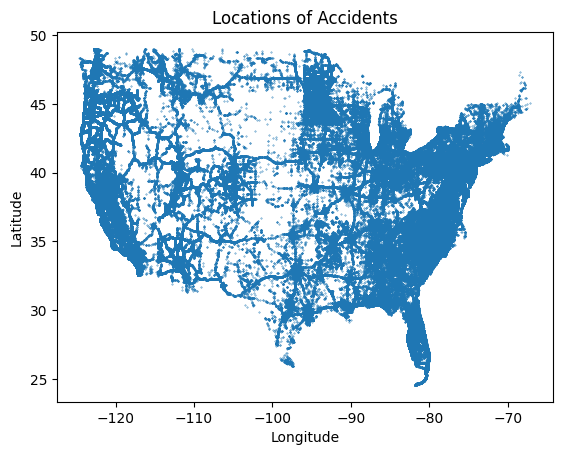

In [64]:
plt.scatter(data['Start_Lng'], data['Start_Lat'], s=0.1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Locations of Accidents")
plt.show()

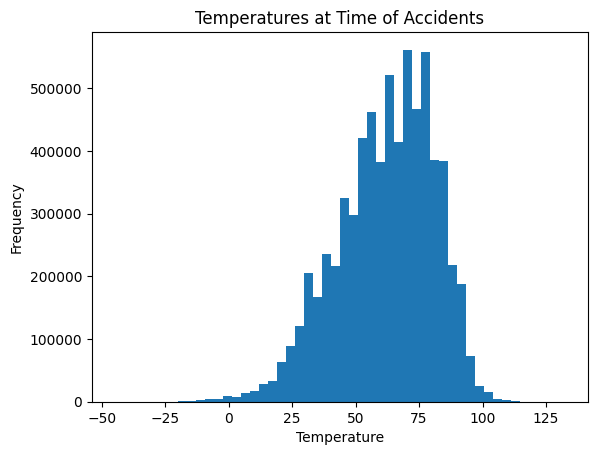

In [ ]:
plt.hist(data['Temperature(F)'], bins=50)
plt.title("Temperatures at Time of Accidents")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [4]:
perc_under_freezing = len(data[data['Temperature(F)'] < 32]) / len(data)
print(perc_under_freezing)

0.07078895202778214


Accident data is around the clock. The sparsest hour is 3am with ~60,000 data points.

In [13]:
# Start time as only times
start_time = pd.to_datetime(data["Start_Time"], format="%Y-%m-%d %H:%M:%S").dt.hour


In [20]:
print(start_time.value_counts().sort_index())

Start_Time
0      95543
1      82033
2      78918
3      71151
4     137781
5     196010
6     349858
7     508810
8     506732
9     321766
10    308596
11    323812
12    324253
13    363672
14    414954
15    489273
16    542655
17    533782
18    395065
19    264180
20    197921
21    167806
22    145609
23    109164
Name: count, dtype: int64


In [23]:
print((start_time.value_counts() / len(start_time)).sort_index())

Start_Time
0     0.013788
1     0.011838
2     0.011389
3     0.010268
4     0.019884
5     0.028287
6     0.050489
7     0.073428
8     0.073128
9     0.046435
10    0.044535
11    0.046731
12    0.046794
13    0.052483
14    0.059884
15    0.070609
16    0.078313
17    0.077032
18    0.057013
19    0.038125
20    0.028563
21    0.024217
22    0.021013
23    0.015754
Name: count, dtype: float64


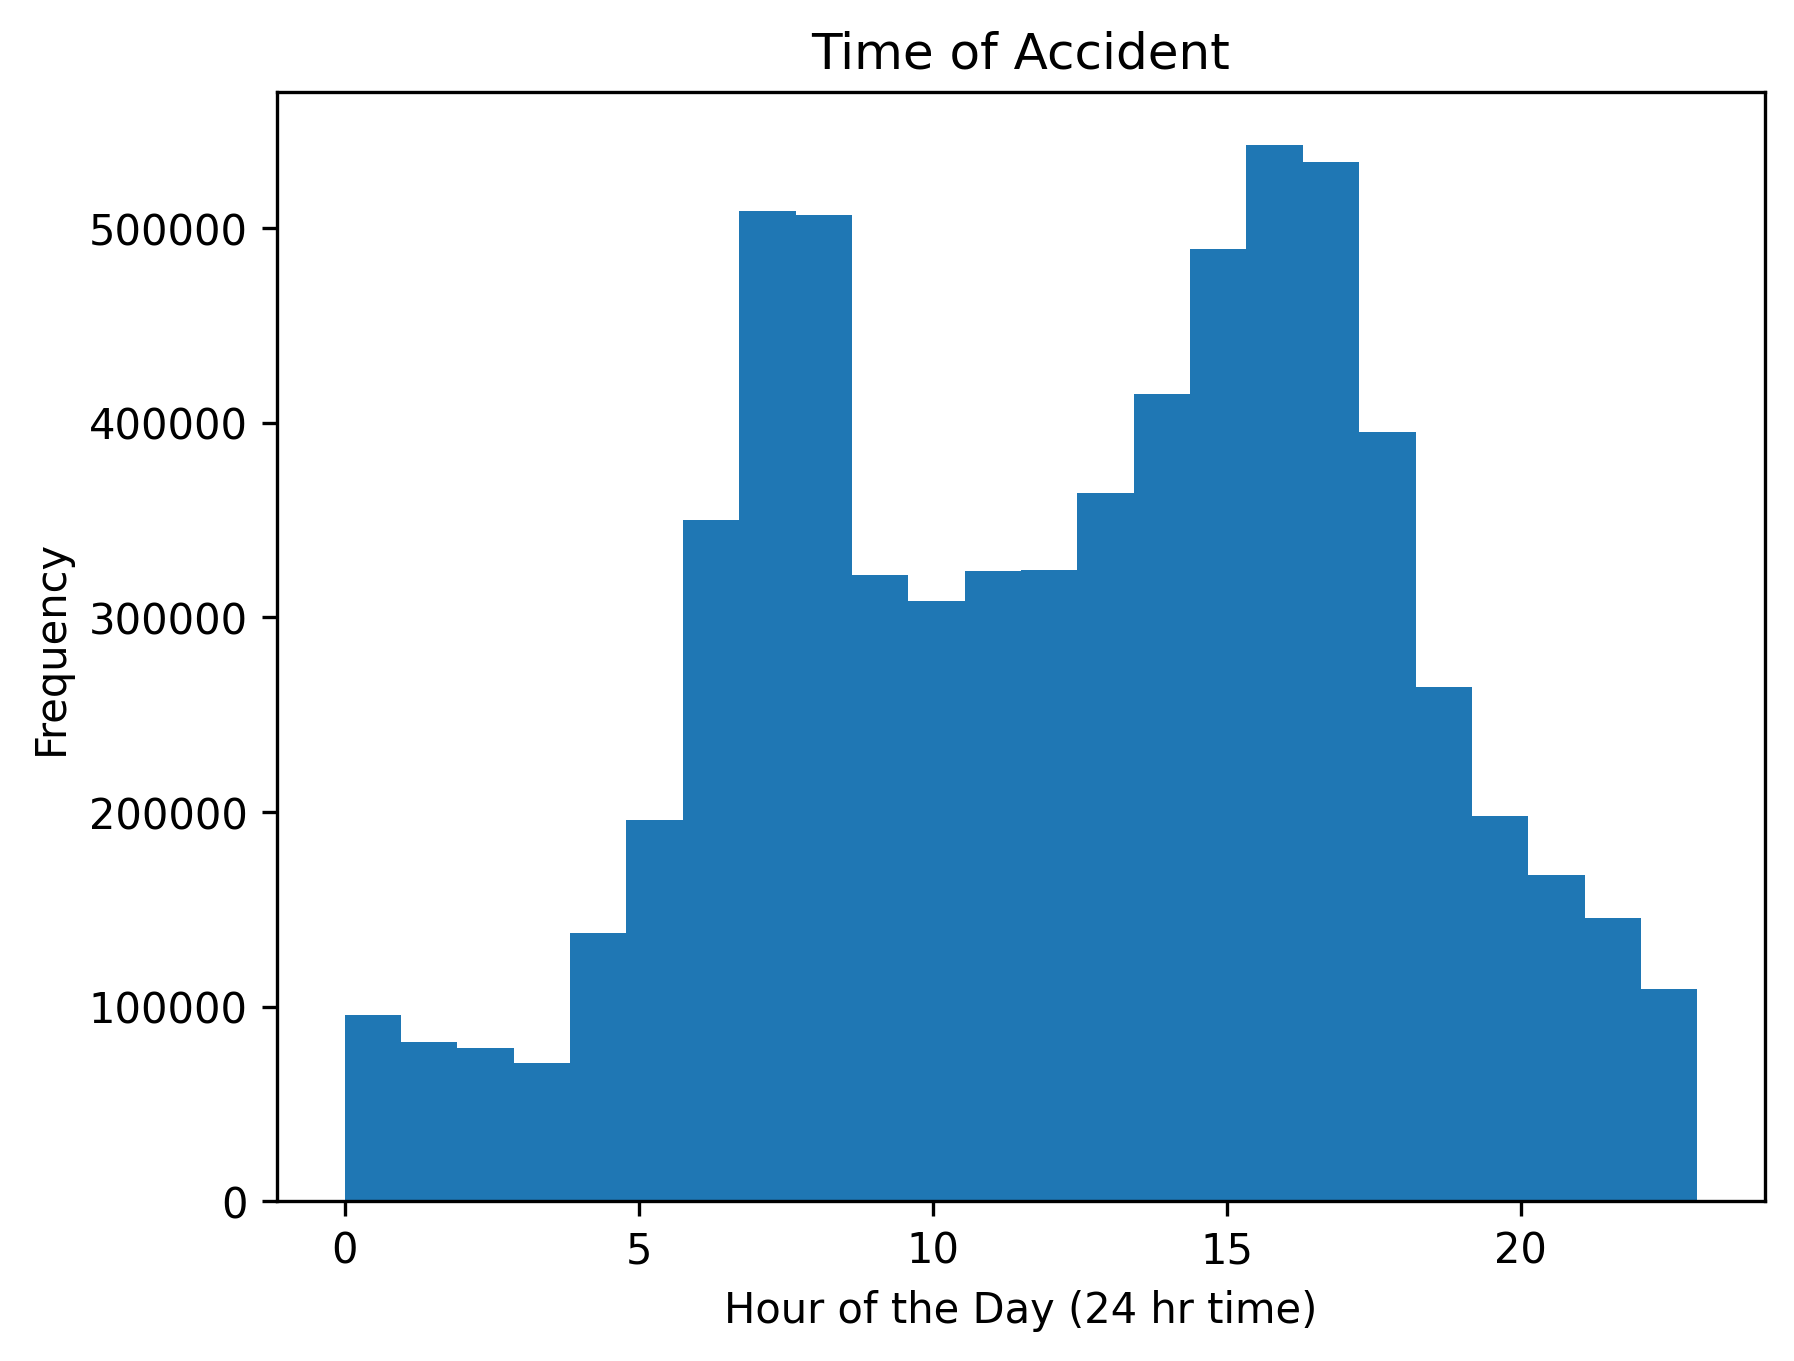

In [22]:
counts, bin_edges, _ = plt.hist(start_time, bins=24)
plt.title("Time of Accident")
plt.xlabel("Hour of the Day (24 hr time)")
plt.ylabel("Frequency")
plt.show()

Sunrise_Sunset / Civil_Twilight / Nautical_Twilight / Astronomical_Twilight only give Day/Night classifications. Weather condition seems to give too many classifications to be useful.

In [ ]:
print(data['Astronomical_Twilight'].unique())

['Day' 'Night']


In [ ]:
print(data['Weather_Condition'].unique())

['Overcast' 'Mostly Cloudy' 'Light Rain' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' 'Light Rain Showers' 'Smoke'
 'Patches of Fog' 'Mist' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust' 'Fair / Windy'
 'Rain Showers' 'Light Rain / Windy' 'Hail' 'Heavy Drizzle'
 'Showers in the Vicinity' 'Light Rain Shower' 'Light Rain with Thunder'
 'Mostly Cloudy / Windy' 'Partly Cloudy / Windy' 'Thunder in the Vicinity'
 'T-Storm' 'Heavy Thunderstorms and Rain' 'Thunderstorm' 'Thunder'
 'Heavy T-Storm' 'Funnel Cloud' 'Heavy T-Storm / Windy' 'Blowing Snow'
 'Light Thunderstorms and Snow' 'Heavy Snow' 'Low Drifting Snow'
 'Light Ice Pellets' 'Ice Pellets' 'Squalls' 'N/A Precipitation'
 'Cloudy / Windy' 'Snow Grains' 'Light Fog' 'Snow Showers'
 'Hea

We need to investigate further what the weather timestamp column is. My suspicion is it corresponds to the time the weather was recorded at the airport weather station, in which case it likely may be removed.

In [65]:
print(data['Weather_Timestamp'])

0          2016-02-08 06:56:00
1          2016-02-08 07:38:00
2          2016-02-08 07:53:00
3          2016-02-08 07:51:00
4          2016-02-08 07:56:00
                  ...         
6929339    2019-08-23 17:53:00
6929340    2019-08-23 18:53:00
6929341    2019-08-23 18:53:00
6929342    2019-08-23 18:51:00
6929343    2019-08-23 20:50:00
Name: Weather_Timestamp, Length: 6929344, dtype: object


Things to discuss:
- which attributes/conditions do we want to train our model on?
- how do we want to determine severity?
- do we want to require a min number of samples per bucket in order to justify using that column? ie state, severity, temperature
- columns to ignore in my opinion - weather condition, sunrise sunset, twilights, some amenities/road structures

### ML methods

Given what we found in the statistics section of our report we will now eliminate more columns which we judge to not be useful.

In [65]:
df = data
df = df.drop(columns = ["Weather_Condition", "Weather_Timestamp"])

We calculate the duration of the closure, and eliminate the end time column. 

In [66]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time']   = pd.to_datetime(df['End_Time'])
df['Total_Time'] = df['End_Time'] - df['Start_Time']
df = df.drop(columns=['End_Time'])

Since the Severity column is so heavily skewed we will create a new metric that our model will try to predict, this will be a combination of the distance of the disruption, how long it occured for, if it occured during a rush hour, all scaled by the severity 

In [67]:
# Calculate the weighted score
df['Total_Time'] = df['Total_Time'].dt.total_seconds() / 3600
df['score'] = df["Severity"]**2 * (1*df['Distance(mi)'] + 0.1*df['Total_Time'])
# We next normalize it 
df['score'] = (np.log1p(df['score']) - np.log1p(df['score'].min()))/ np.log1p((df['score'].max()) - np.log1p(df['score'].min()))
# Now we drop the columns we used to make it
df = df.drop(columns=['Total_Time', 'Severity','Distance(mi)' ])


Next we examine the distribution of our new scores

In [30]:
df['score'].describe()

count    6.929344e+06
mean     1.297995e-01
std      6.985400e-02
min      0.000000e+00
25%      8.118534e-02
50%      1.147431e-01
75%      1.637927e-01
max      9.905524e-01
Name: score, dtype: float64

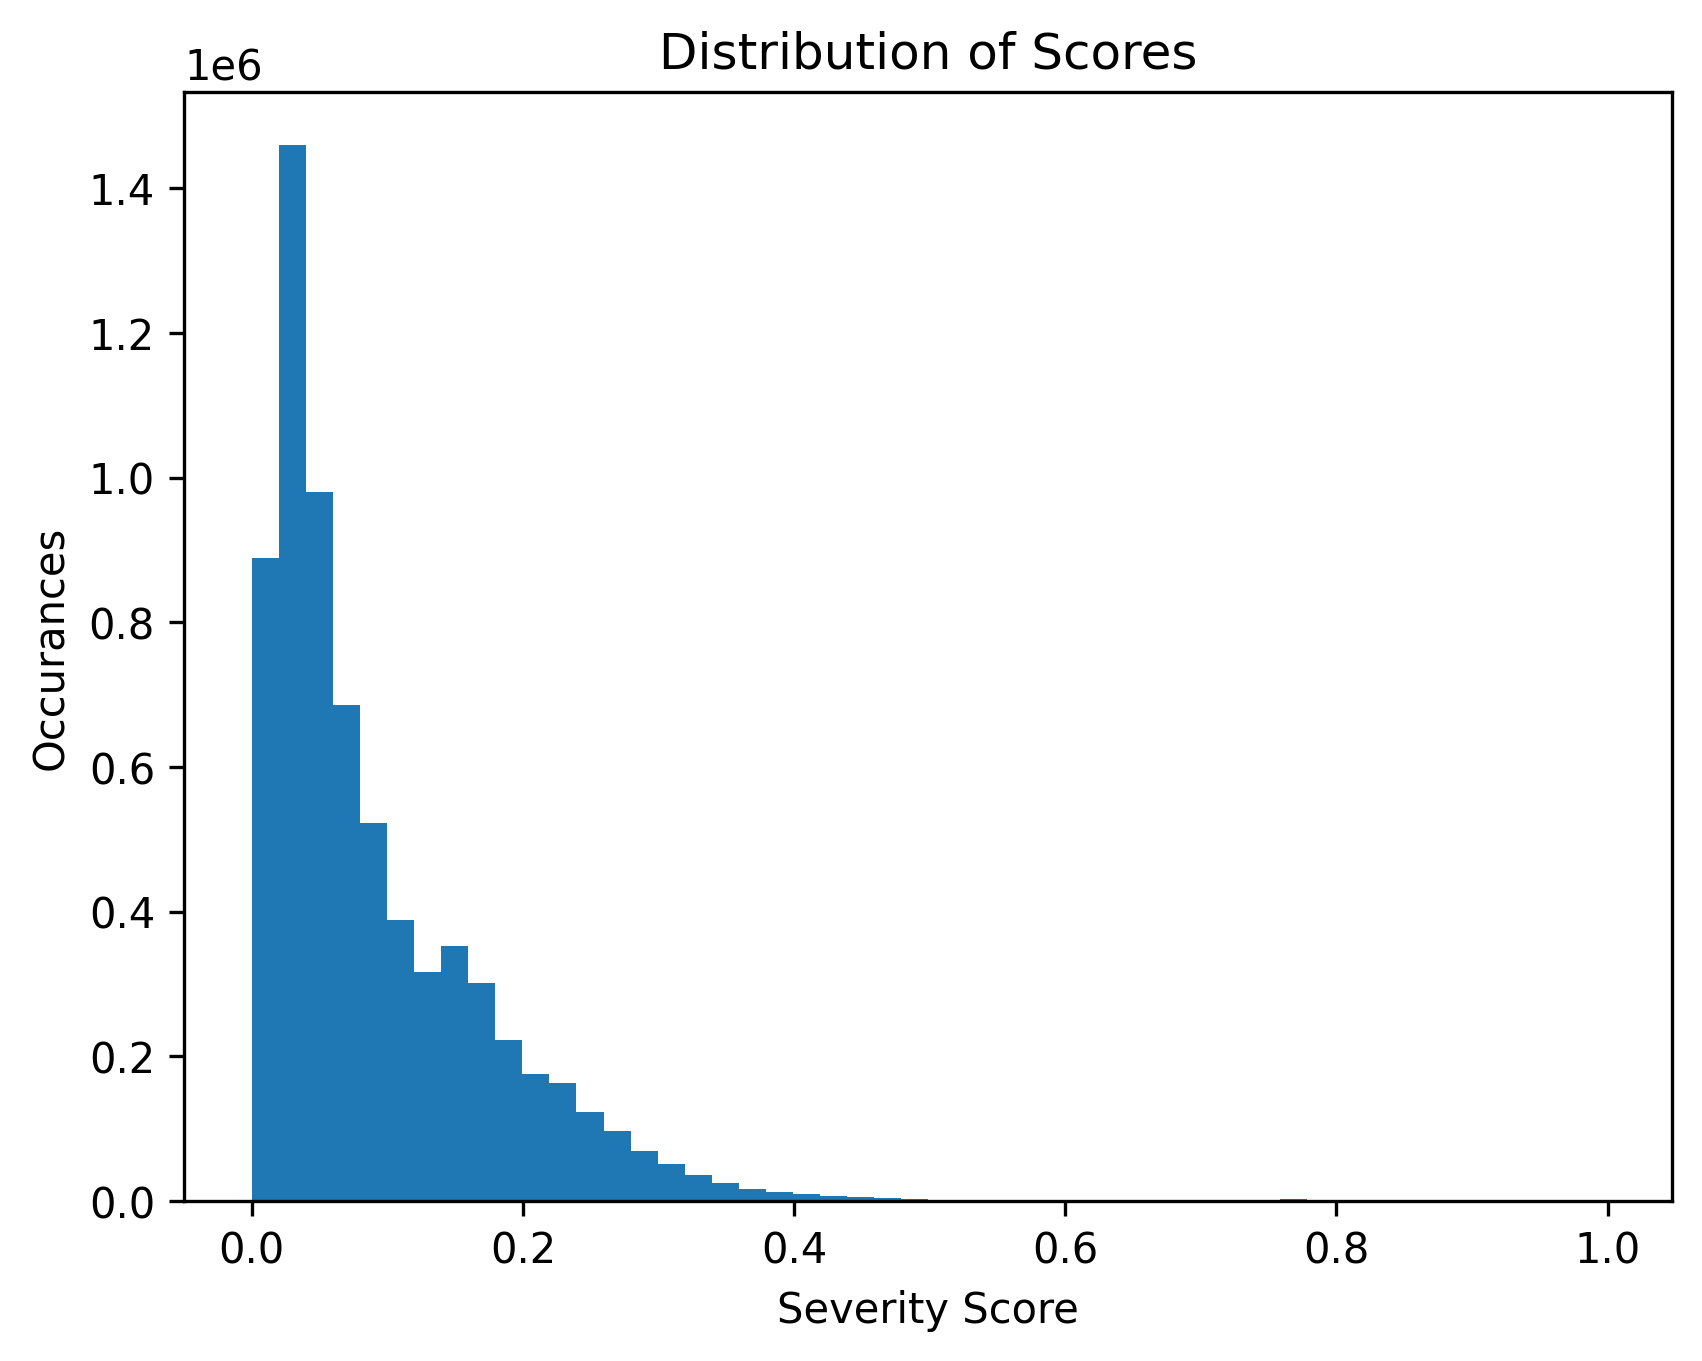

In [68]:
plt.hist(df['score'], bins=50)
plt.title("Distribution of Scores")
plt.ylabel("Occurances")
plt.xlabel('Severity Score')
plt.show()

Now we get rid of all but one of the indicators of daylight, as well as city, county, zipcode and state

In [69]:
df['Start_Time_hour'] = df['Start_Time'].dt.hour
df['Start_Time_dow']  = df['Start_Time'].dt.dayofweek     
df['Start_Time_dom']  = df['Start_Time'].dt.day          
df['Start_Time_month'] = df['Start_Time'].dt.month
df['Start_Time_year'] = df['Start_Time'].dt.year
df = df.drop(columns=['Sunrise_Sunset','Nautical_Twilight', 'Astronomical_Twilight', 'City', 'County', 'State', 'Zipcode', 'Wind_Direction', 'Start_Time'])

Here we make a table to visualize the features used in our analysis

In [70]:
print(cols)

37


Now we are ready to prepare our data for use in an ML pipeline 

In [71]:
y = df['score']
# Drop score
x = df.drop(columns=['score'])
# One hot encode Civil Twilight
x = pd.get_dummies(x, drop_first=True)



We split into training and test sets

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=7)

Scale data

In [74]:
# We must scale the data for KMeans and PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrainscale = scaler.fit_transform(xtrain)
xtestscale = scaler.fit_transform(xtest)

K-Means Clustering

In [77]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=7)
kmeans.fit(xtrainscale)

cluster_labels = kmeans.predict(xtestscale)

/Users/alicelundgren/Desktop/всё/ACME/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [79]:
print(cluster_labels[:15])
print(ytest[:15])

[ 1  9  2 17  7  1  6  1  3 17 15 13  2  6  6]
4276667    0.171775
5646863    0.310478
6852109    0.158836
5319112    0.080225
2912337    0.014661
3653031    0.071392
3449003    0.194187
3286215    0.086296
673883     0.022063
3309270    0.182307
1754492    0.340062
250118     0.017603
1737648    0.045699
586812     0.015890
4347508    0.080705
Name: score, dtype: float64


In [ ]:
# round labels to nearest 0.2 since 20 bins w our score distribution is approximately every 0.2
rounded_pt2 = round(y / 0.2) * 0.2

[1 0 1 ... 1 1 2]


K Means clustering is difficult for predicting a score because it outputs data in bins, but each bin does not necessarily correspond with a particular range of numbers

PCA 

**Model and Prediction**

We first try a random forest

In [81]:
# Cells for building models and making predictions 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=7, n_jobs=-1)
rf.fit(xtrain, ytrain)
pred = rf.predict(xtest)
mse = mean_squared_error(ytest, pred)

In [82]:
print(mse)

0.006173550288906031


In [83]:
importances = pd.Series(rf.feature_importances_, index=xtrain.columns)
importances.sort_values(ascending=False).head(20)

Start_Time_year     0.569126
Traffic_Signal      0.300119
Start_Lat           0.074281
Crossing            0.048087
Start_Lng           0.005343
Start_Time_hour     0.003044
Railway             0.000000
Start_Time_month    0.000000
Start_Time_dom      0.000000
Start_Time_dow      0.000000
Turning_Loop        0.000000
Traffic_Calming     0.000000
Stop                0.000000
Station             0.000000
Roundabout          0.000000
No_Exit             0.000000
Junction            0.000000
Give_Way            0.000000
Bump                0.000000
Amenity             0.000000
dtype: float64

<AxesSubplot: >

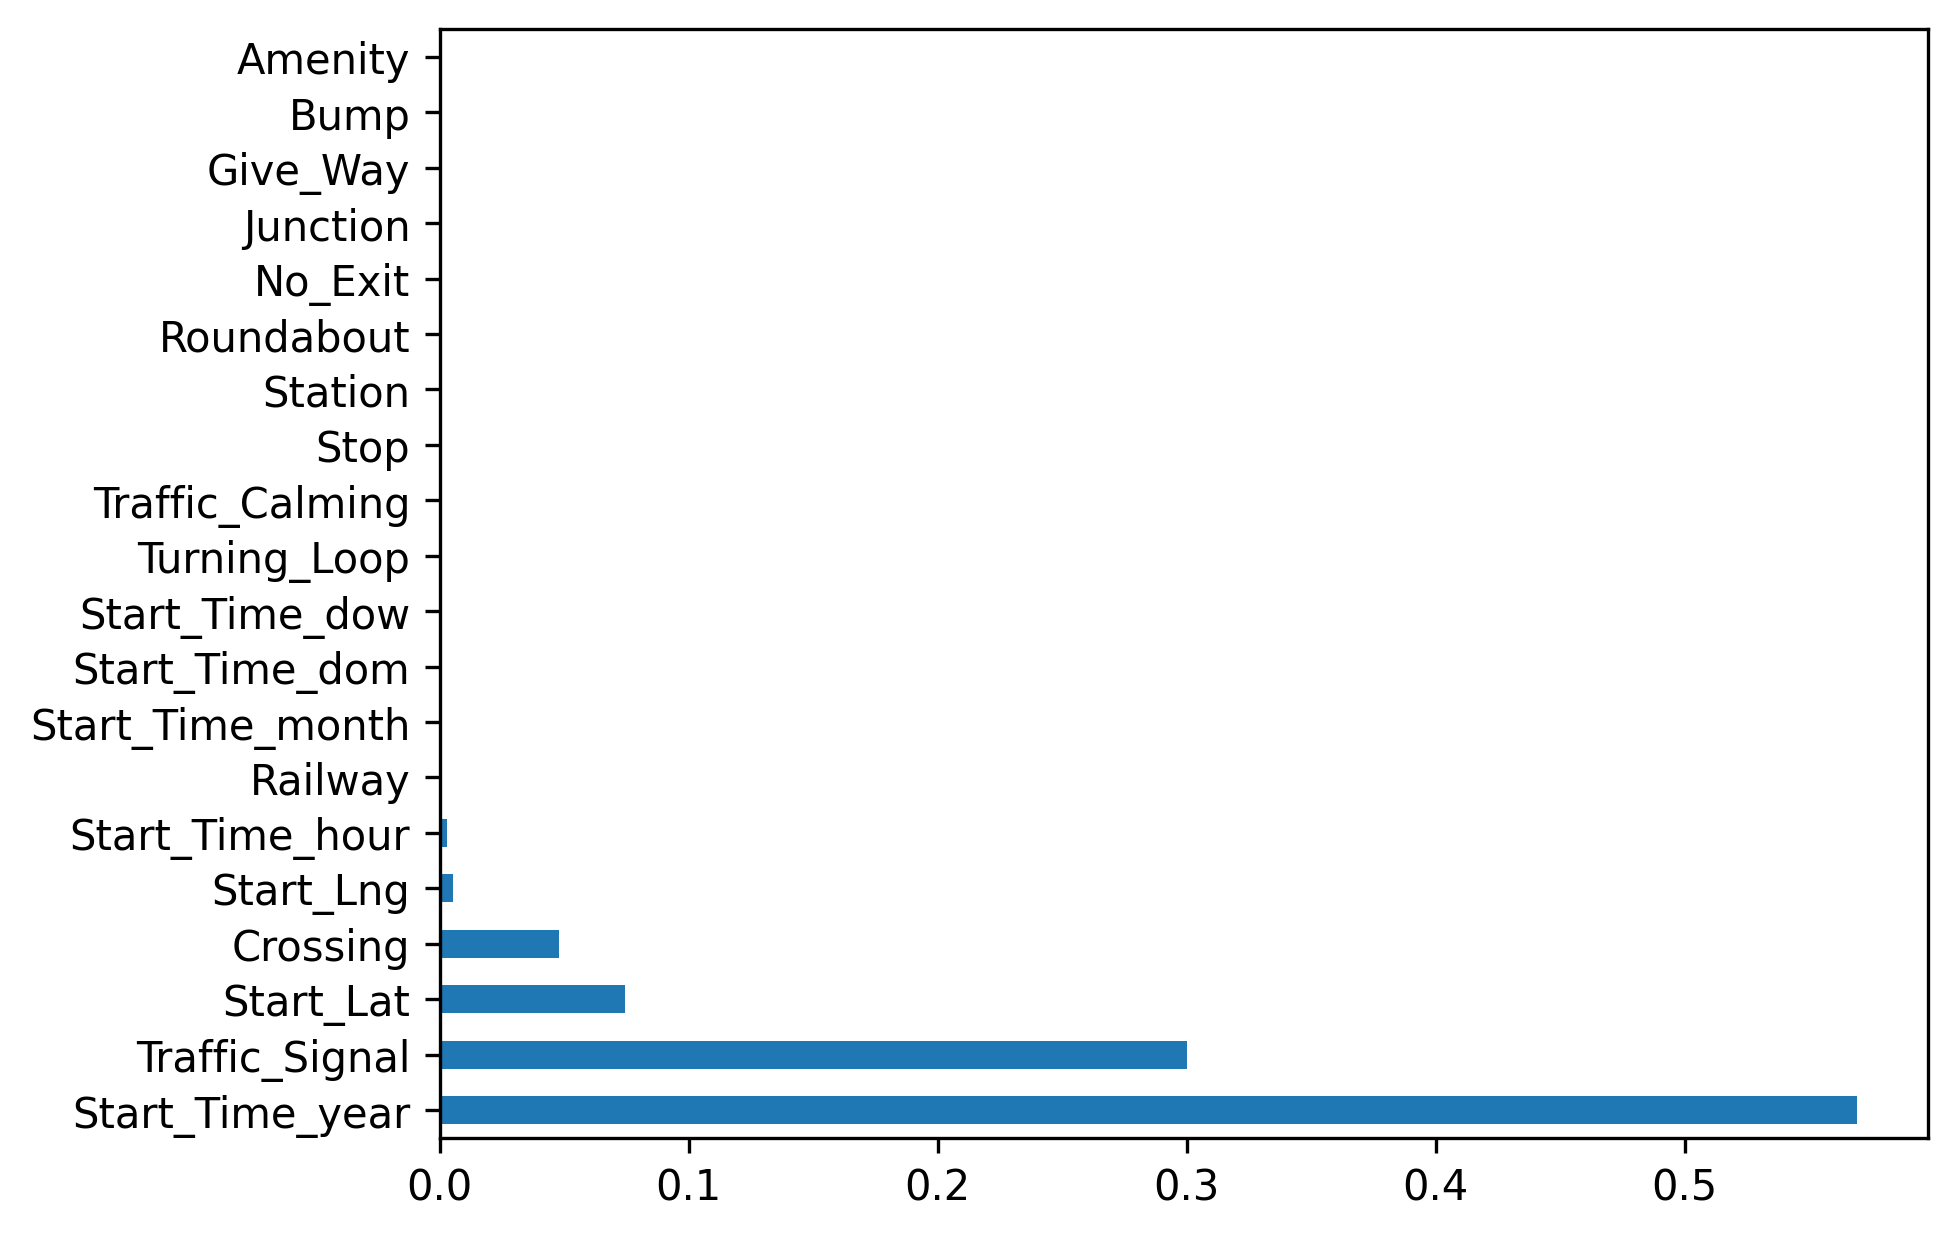

In [84]:
importances.sort_values(ascending=False).head(20).plot(kind='barh')